# VGG16 - DeepFake Detection

In [1]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import torch
import torch.nn.functional as F

from torch import nn
from torch import optim
from tqdm import tqdm 
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix

# DeepFake detection dataset

In [3]:
#training, validation, and test data

train_dir = r"E:\BigdataandAI\sem2\AI2 Project work\data for experiments\split_dataset\train"
valid_dir = r"E:\BigdataandAI\sem2\AI2 Project work\data for experiments\split_dataset\val"
test_dir = r"E:\BigdataandAI\sem2\AI2 Project work\data for experiments\split_dataset\test"

In [4]:
# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)

# Design & architecture

In [5]:
# Load pretrained VGG-16 Model

model = models.vgg16(pretrained=True)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(4096, 2)),
                                        ('output', nn.Sigmoid())]))

model.classifier = classifier

# Define loss function with Adam optimizer

In [7]:
# Loss function and gradient descent

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Model training

In [8]:
# Define training accuracy & loss 

train_accu = []
train_losses = []

# Function for defining the train
def train(epoch):
    
    print('\nEpoch : %d'%epoch)
    model.train()
 
    running_loss=0
    correct=0
    total=0
    CM=0
 
    for data in tqdm(train_loader):

        inputs,labels=data[0],data[1]
     
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
 
        running_loss += loss.item()
     
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        CM+=confusion_matrix(labels, predicted,labels=[0,1])
      
        tn=int(CM[0][0])
        tp=int(CM[1][1])
        fp=int(CM[0][1])
        fn=int(CM[1][0])
    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
    sensitivity=tp/(tp+fn)
    precision=tp/(tp+fp)
   
    train_accu.append(accu)
    train_losses.append(train_loss)
    
    # Print performance metric values
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
    print('- Sensitivity : ',(tp/(tp+fn))*100)
    print('- Specificity : ',(tn/(tn+fp))*100)
    print('- Precision: ',(tp/(tp+fp))*100)
    

In [9]:
# Define validation accuracy & loss

eval_losses=[]
eval_accu=[]
 
# Function for defining the validation
def validation(epoch):
    
    model.eval()
 
    running_loss=0
    correct=0
    total=0
    CM=0
 
    with torch.no_grad():
        for data in tqdm(validate_loader):
            
            images,labels=data[0],data[1]
            outputs=model(images)
 
            loss= loss_fn(outputs,labels)
            running_loss+=loss.item()
       
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            CM+=confusion_matrix(labels, predicted, labels=[0,1])
   
        tn=int(CM[0][0])
        tp=int(CM[1][1])
        fp=int(CM[0][1])
        fn=int(CM[1][0])
    validate_loss=running_loss/len(validate_loader)
    accu=100.*correct/total
    sensitivity=tp/(tp+fn)
    precision=tp/(tp+fp)
 
    eval_losses.append(validate_loss)
    eval_accu.append(accu)
 
    # Print performance metric values
    print('Validate Loss: %.3f | Accuracy: %.3f'%(validate_loss,accu))
    print('- Sensitivity : ',(tp/(tp+fn))*100)
    print('- Specificity : ',(tn/(tn+fp))*100)
    print('- Precision: ',(tp/(tp+fp))*100)
  

In [10]:
# Training the model for 15 epochs

epochs=15
for epoch in range(1,epochs+1): 
    
    train(epoch)
    validation(epoch)

  0%|                                                                                          | 0/973 [00:00<?, ?it/s]


Epoch : 1


100%|██████████████████████████████████████████████████████████████████████████████| 973/973 [2:14:42<00:00,  8.31s/it]


Train Loss: 0.519 | Accuracy: 78.137
- Sensitivity :  85.33724340175954
- Specificity :  67.70997168921045
- Precision:  79.28355196770939


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.445 | Accuracy: 86.471
- Sensitivity :  83.1304347826087
- Specificity :  91.30982367758187
- Precision:  93.26829268292684

Epoch : 2


100%|██████████████████████████████████████████████████████████████████████████████| 973/973 [2:16:44<00:00,  8.43s/it]


Train Loss: 0.487 | Accuracy: 81.542
- Sensitivity :  87.27055501249049
- Specificity :  73.24630386914124
- Precision:  82.52875924404273


100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [13:19<00:00,  6.55s/it]


Validate Loss: 0.411 | Accuracy: 89.918
- Sensitivity :  94.43478260869566
- Specificity :  83.37531486146096
- Precision:  89.16256157635468

Epoch : 3


100%|██████████████████████████████████████████████████████████████████████████████| 973/973 [2:28:09<00:00,  9.14s/it]


Train Loss: 0.480 | Accuracy: 82.506
- Sensitivity :  87.90051048115565
- Specificity :  74.69329977980496
- Precision:  83.4157905586477


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.406 | Accuracy: 90.175
- Sensitivity :  90.43478260869566
- Specificity :  89.7984886649874
- Precision:  92.7743086529884

Epoch : 4


100%|██████████████████████████████████████████████████████████████████████████████| 973/973 [2:28:29<00:00,  9.16s/it]


Train Loss: 0.471 | Accuracy: 83.611
- Sensitivity :  87.67242315629412
- Specificity :  77.72884554891475
- Precision:  85.07588532883642


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.403 | Accuracy: 90.586
- Sensitivity :  92.34782608695652
- Specificity :  88.0352644836272
- Precision:  91.78910976663785

Epoch : 5


100%|██████████████████████████████████████████████████████████████████████████████| 973/973 [2:29:13<00:00,  9.20s/it]


Train Loss: 0.469 | Accuracy: 83.797
- Sensitivity :  88.23721081785598
- Specificity :  77.36709657124882
- Precision:  84.95242078845551


100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [13:36<00:00,  6.69s/it]


Validate Loss: 0.406 | Accuracy: 90.278
- Sensitivity :  95.04347826086956
- Specificity :  83.37531486146096
- Precision:  89.22448979591837

Epoch : 6


100%|██████████████████████████████████████████████████████████████████████████████| 973/973 [2:31:31<00:00,  9.34s/it]


Train Loss: 0.468 | Accuracy: 83.810
- Sensitivity :  88.28065602259151
- Specificity :  77.33564013840831
- Precision:  84.94095516772913


100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [13:25<00:00,  6.60s/it]


Validate Loss: 0.440 | Accuracy: 86.986
- Sensitivity :  81.56521739130434
- Specificity :  94.83627204030228
- Precision:  95.81205311542391

Epoch : 7


100%|██████████████████████████████████████████████████████████████████████████████| 973/973 [2:30:06<00:00,  9.26s/it]


Train Loss: 0.461 | Accuracy: 84.510
- Sensitivity :  88.79113717823395
- Specificity :  78.3107895564643
- Precision:  85.56625497173958


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.418 | Accuracy: 89.403
- Sensitivity :  86.78260869565217
- Specificity :  93.19899244332494
- Precision:  94.86692015209125

Epoch : 8


100%|██████████████████████████████████████████████████████████████████████████████| 973/973 [2:31:32<00:00,  9.35s/it]


Train Loss: 0.456 | Accuracy: 85.108
- Sensitivity :  89.75779298359944
- Specificity :  78.37370242214533
- Precision:  85.7350347546426


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.418 | Accuracy: 88.940
- Sensitivity :  85.47826086956522
- Specificity :  93.95465994962217
- Precision:  95.3443258971872

Epoch : 9


  0%|                                                                                          | 0/122 [00:00<?, ?it/s]

Train Loss: 0.456 | Accuracy: 85.114
- Sensitivity :  90.34430324752906
- Specificity :  77.54010695187165
- Precision:  85.34783500923456


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.401 | Accuracy: 90.895
- Sensitivity :  95.3913043478261
- Specificity :  84.38287153652394
- Precision:  89.84438984438985

Epoch : 10


  0%|                                                                                          | 0/122 [00:00<?, ?it/s]

Train Loss: 0.456 | Accuracy: 84.966
- Sensitivity :  88.62821766047573
- Specificity :  79.66341616860649
- Precision:  86.32180260234847


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.400 | Accuracy: 90.998
- Sensitivity :  90.26086956521739
- Specificity :  92.06549118387909
- Precision:  94.27792915531336

Epoch : 11


  0%|                                                                                          | 0/122 [00:00<?, ?it/s]

Train Loss: 0.448 | Accuracy: 85.904
- Sensitivity :  88.8237210817856
- Specificity :  81.6766278703995
- Precision:  87.53077170073851


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.392 | Accuracy: 92.027
- Sensitivity :  95.56521739130434
- Specificity :  86.90176322418137
- Precision:  91.35494596841231

Epoch : 12


  0%|                                                                                          | 0/122 [00:00<?, ?it/s]

Train Loss: 0.451 | Accuracy: 85.718
- Sensitivity :  90.04018681438036
- Specificity :  79.45894935514313
- Precision:  86.39016256773657


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.413 | Accuracy: 89.506
- Sensitivity :  85.73913043478261
- Specificity :  94.96221662468514
- Precision:  96.10136452241716

Epoch : 13


  0%|                                                                                          | 0/122 [00:00<?, ?it/s]

Train Loss: 0.451 | Accuracy: 85.866
- Sensitivity :  89.8989898989899
- Specificity :  80.02516514627241
- Precision:  86.6973918508432


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.433 | Accuracy: 87.551
- Sensitivity :  98.52173913043478
- Specificity :  71.66246851385391
- Precision:  83.43151693667158

Epoch : 14


  0%|                                                                                          | 0/122 [00:00<?, ?it/s]

Train Loss: 0.451 | Accuracy: 85.544
- Sensitivity :  89.76865428478332
- Specificity :  79.4274929223026
- Precision:  86.3365716076465


  0%|                                                                                          | 0/973 [00:00<?, ?it/s]

Validate Loss: 0.391 | Accuracy: 92.233
- Sensitivity :  96.69565217391303
- Specificity :  85.76826196473552
- Precision:  90.77551020408163

Epoch : 15


  0%|                                                                                          | 0/122 [00:00<?, ?it/s]

Train Loss: 0.447 | Accuracy: 86.052
- Sensitivity :  90.12707722385142
- Specificity :  80.15099087763447
- Precision:  86.79916317991632


100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [06:09<00:00,  3.03s/it]


Validate Loss: 0.448 | Accuracy: 86.008
- Sensitivity :  78.17391304347827
- Specificity :  97.35516372795969
- Precision:  97.71739130434783


# Saving the model

In [11]:
# Save the checkpoint

def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'DF_pytorch_vgg16_15epochs_lr0.0001.pth ')
    
save_checkpoint(model)  

# Learning curves

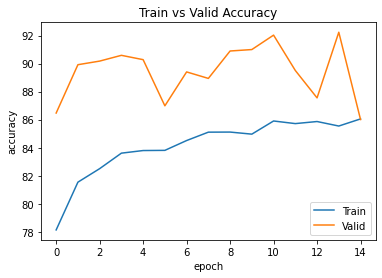

In [12]:
#training & validation accuracy plots

plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

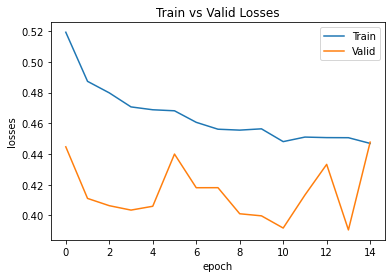

In [13]:
#training & validation loss plots

plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

# Testing model

In [14]:
#Defining test function with test results

def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()

    with torch.no_grad():
    
        accuracy = 0
        CM=0
    
        for images, labels in iter(test_loader):
    
            output = model.forward(images)

            probabilities = torch.exp(output)
            preds = torch.argmax(output.data, 1)
            
            CM+=confusion_matrix(labels, preds, labels=[0,1])
        
            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
            tn=CM[0][0]
            tp=CM[1][1]
            fp=CM[0][1]
            fn=CM[1][0]
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)
        f1_score=((2*sensitivity*precision)/(sensitivity+precision))
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))     
        print('Sensitivity : ',(tp/(tp+fn))*100)
        print('Specificity : ',(tn/(tn+fp))*100)
        print('Precision: ',(tp/(tp+fp))*100)
        print('Confusion Matrix', CM)
        print('F1-score', f1_score)

        
test_accuracy(model, test_loader)

Test Accuracy: 0.8624853491783142
Sensitivity :  78.47222222222221
Specificity :  97.48743718592965
Precision:  97.83549783549783
Confusion Matrix [[776  20]
 [248 904]]
F1-score 0.8709055876685934


In [15]:
#Summary of the model

from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,